In [1]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from datasets import load_from_disk
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
project_root = Path.cwd().parent
data_path = project_root / "data"  / "validation"

dataset = load_from_disk(str(data_path))
sample = dataset[0]  
image = sample["image"] 
question = sample["question"]
answer = sample["answer"]

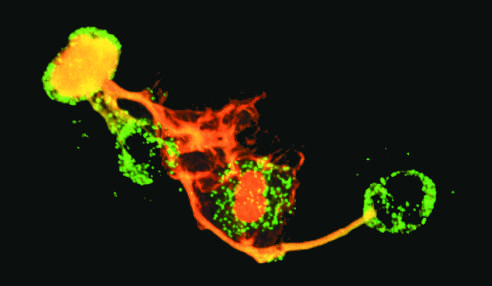

In [3]:
image

In [4]:
question

'what have lost their nuclei?'

In [5]:
answer

'neutrophils'

In [6]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image

In [16]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"  # <== das ist wichtig!
)


C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\venv\Lib\site-packages\accelerate\utils\modeling.py:1569: UserWarning: Current model requires 4776 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu and disk.


In [17]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")


In [18]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question}
        ]
    }
]

In [19]:
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [20]:
image_inputs, video_inputs = process_vision_info(messages)

In [21]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
).to(model.device)

In [22]:
# Modell mit aktivierten Attention-Outputs ausführen
with torch.no_grad():
    outputs = model(
        **inputs,
        output_attentions=True,
        return_dict=True
    )

In [23]:
# Attention-Maps extrahieren
attentions = outputs.attentions  # Liste von Attention-Maps pro Layer


In [24]:
# Beispiel: Visualisierung der Attention des letzten Layers
last_layer_attention = attentions[-1]  # Form: (batch_size, num_heads, seq_len, seq_len)
avg_attention = last_layer_attention[0].mean(dim=0).to(torch.float32).cpu().numpy()



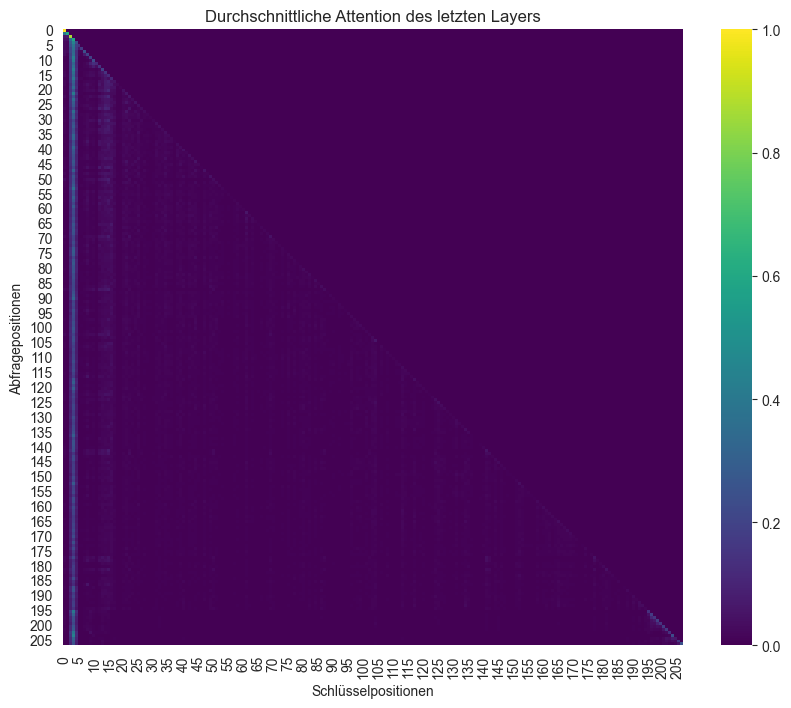

In [25]:
# Visualisierung
plt.figure(figsize=(10, 8))
sns.heatmap(avg_attention, cmap="viridis")
plt.title("Durchschnittliche Attention des letzten Layers")
plt.xlabel("Schlüsselpositionen")
plt.ylabel("Abfragepositionen")
plt.show()

# Neuer Abschnitt mit captum


In [30]:
from captum.attr import IntegratedGradients, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import torch


In [31]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="eager"
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu and disk.


Qwen2_5_VLForConditionalGeneration(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )
    )
    (merger): Qwen2_5_VLPatchMerger(
  

In [32]:
# 2. Lade den passenden Tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")


In [33]:
inputs = tokenizer(question, return_tensors="pt").to(model.device)


In [35]:
model.model.embed_tokens


Embedding(151936, 2048)

In [36]:
# 4. Embedding-Ebene austauschbar machen
interpretable_emb = configure_interpretable_embedding_layer(model, "model.embed_tokens")



C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\venv\Lib\site-packages\captum\attr\_models\base.py:206: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [45]:
input_ids = inputs["input_ids"]

In [46]:
input_embeds = interpretable_emb.indices_to_embeddings(input_ids)


In [47]:
target_token = "neutrophils"
target_id = tokenizer.convert_tokens_to_ids(target_token)

In [48]:
def forward_func(input_embeds):
    outputs = model(inputs_embeds=input_embeds, attention_mask=inputs["attention_mask"])
    return outputs.logits[:, -1, target_id]  # <- Jetzt erklärst du das Logit für "elephant"


In [49]:
baseline_ids = torch.full_like(input_ids, tokenizer.pad_token_id)


In [50]:
baseline_embeds = interpretable_emb.indices_to_embeddings(baseline_ids)

In [51]:
ig = IntegratedGradients(forward_func)

In [ ]:
attributions = ig.attribute(input_embeds, baselines=baseline_embeds,
                            target=target_id)


In [ ]:
# 9. Attribution über Embedding-Dimension mitteln
word_attributions = attributions.sum(dim=-1).squeeze(0)  # shape: (seq_len,)


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0))


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import torch

def visualize_word_importance(question_tokens, attributions, title="Word Importance"):
    """
    Visualisiert Wortwichtigkeit als farbige Textboxen (rot = unwichtig, grün = wichtig).
    """
    attributions = attributions.detach().cpu().numpy()
    norm_attr = (attributions - attributions.min()) / (attributions.max() - attributions.min() + 1e-8)

    # Farbverlauf: rot → weiß → grün
    cmap = LinearSegmentedColormap.from_list("importance", ["red", "white", "green"])

    fig, ax = plt.subplots(figsize=(len(question_tokens), 1.5))
    for i, word in enumerate(question_tokens):
        ax.text(i, 0, word, fontsize=12, ha="center", va="center",
                bbox=dict(facecolor=cmap(norm_attr[i]), edgecolor='none', boxstyle='round,pad=0.3'))
    ax.set_xlim(-1, len(question_tokens))
    ax.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
visualize_word_importance(tokens, word_attributions, title="Word Attribution (IG)")